<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Introduction to the LSST deblender data products</b> <br>
Contact author(s): Christina WIlliams <br>
Last verified to run: 2024-01-31 <br>
LSST Science Pipelines version: Weekly 2024_04 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** This tutorial introduces the data products created by the LSST multiband deblender (Scarlet; <a href="https://ui.adsabs.harvard.edu/abs/2018A%26C....24..129M/abstract">Melchior et al. 2018</a>) and illustrates some simple use cases for them.  **Adapted to use the dp02_dc2_catalogs_frdf catalogs produced at CC-IN2P3 and CC-IN2P3 butler.**

**Skills:** Use of the catalog data products related to deblending objects.

**LSST Data Products:** images (deepCoadd, skyMap, MaskedImage) and catalogs (objectTable)

**Packages:** lsst.afw.image, lsst.afw.detection, lsst.rsp, lsst.daf.butler, lsst.geom

**Credit:** Developed by Christina Willliams in collaboration with Melissa Graham and the Rubin Community Science Team for DP0.2.
Influenced by Stack Club notebooks demonstrating how to run the LSST deblender (Scarlet; Melchior et al. 2018) by Fred Moolekamp and Alex Drlica-Wagner. 

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook is an introduction to the data products that are associated with the deblending process.

In order to build its source catalog and measure photometry of objects in images, the LSST Science Pipeline uses the multi-wavelength deblending algorithm Scarlet (<a href="https://ui.adsabs.harvard.edu/abs/2018A%26C....24..129M/abstract">Melchior et al. 2018</a>) to identify independent detected components within source blends and separate the flux from independent objects.

A "**parent**" source is identified as a region of connected pixels above a given signal-to-noise ratio (S/N) in the `deepCoadd` image.
These regions are called footprints.
Each footprint may have one or more peaks, and it is these peaks that the deblender will use to infer the number and positions of objects blended in each footprint.
The deblended sub-peaks are referred to as "**children**" of the parent in the properties saved by the deblender in the `Object` table.

The Scarlet deblender separates the flux among components by modeling the flux and shape of each source making up the blend.

This tutorial will identify a heavily blended parent object with many children and explore how to interpret the deblender-related measurements in the `Object` table.
It will also demonstrate how to use deblender-related columns in the `Object` table to identify unique deblended child sources, and
provide an example of how to access metadata that is available for each deblended source (e.g. the deblended footprints and pixel-weight maps).

#### Additional resources

An introduction to all of the available deblending flags, and the processes that produce the deblender data products discussed in this tutorial
can be found in this <a href="https://pipelines.lsst.io/modules/lsst.pipe.tasks/deblending-flags-overview.html">overview of the deblending flags</a>.

A general discussion of blending impacts to LSST can be found in this article titled "<a href="https://lss.fnal.gov/archive/2021/pub/fermilab-pub-21-598-ppd.pdf">The challenge of blending in large sky surveys</a>" by Melchior et al. 2021. 

Some more in-depth presentations on the deblending implementation in the LSST Science Pipelines are available from recorded talks during the Rubin Project and Community Workshop 2022's session on "<a href="https://project.lsst.org/meetings/rubin2022/agenda/deblending-plans-and-challenges">Deblending Plans and Challenges</a>". 

### 1.1. Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The `lsst.afw.image` and `lsst.afw.detection` packages provide access to some of the extended products created by the deblender pipeline. 

The `lsst.afw.display` library provides access to image visualization routines and the `lsst.daf.butler` library is used to access data products via the butler.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lsst.daf.butler as Butler
from lsst.rsp import get_tap_service
import lsst.geom as geom
import lsst.afw.display as afwDisplay
from lsst.afw.image import MaskedImage

### 1.2. Define functions and parameters

The following two functions enable the visualization of deblended products:
 1. `cutout_coadd` will make an image cutout (see DP0.2 tutorial notebook 03a on image display).
 2. `heavyFootprint2Image` will help us grab the "footprint" of deblended objects for further analysis.

In [2]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    print("bbox = ", bbox, "xy = ", xy, "cutoutSize = ", cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [3]:
def heavyFootprint2Image(heavy, fill=np.nan, bbox=None, imageType=MaskedImage):
    """
    Create an image of a HeavyFootprint
    Written by Fred Moolekamp

    Parameters
    ----------
    heavy : `HeavyFootprint`
        The HeavyFootprint to insert into the image
    fill: number
        Number to fill the pixels in the image that are not
        contained in `heavy`.
    bbox : `Box2I`
        Bounding box of the output image.
    imageType : `type`
        This should be either a `MaskedImage` or `Image` and describes
        the type of the output image.

    Returns
    -------
    image : `lsst.afw.image.MaskedImage` or `lsst.afw.image.Image`
        An image defined by `bbox` and padded with `fill` that
        contains the projected flux in `heavy`.
    """
    if bbox is None:
        bbox = heavy.getBBox()
    image = imageType(bbox, dtype=heavy.getImageArray().dtype)
    image.set(fill)
    heavy.insert(image)
    return image

Define parameters for plotting.

In [4]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'}
plt.rcParams.update(params)

Start the TAP service.

In [5]:
service = get_tap_service("tap")
assert service is not None

Instantiate the butler.

In [13]:
butler = Butler.Butler('/sps/lsst/dataproducts/rubin/previews/dp0.2/', collections='2.2i/runs/FRDF/DP0.2/PREOPS-1145/step_all')

## 2. The deblender data products

The object and source catalogs contain a number of columns that can be used to identify and characterize blended sources (parents) that have been deblended into child sources, both of which are ultimately stored in the catalogs along with isolated single sources that do not require deblending.
These columns help the user identify a unique sample and avoid returning duplicate objects in queries.

In this tutorial we will focus on deblending data products for `Objects` detected and measured in the `deepCoadd` images.

The following describes boolean flags that are set by the deblender, and some measurements or properties of deblended sources that can be used to characterize (de)blended sources.

> **Note:** This tutorial uses catalog data that are available via TAP **and/or** the butler.
In the DP0-era, some deblending data products are available *only* via butler-based catalogs, and cannot be accessed by TAP and are not listed in the <a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html">DP0.2 Schema Browser</a>.

**Available in the TAP `Object` table and in the butler-based `objectTable`**:

`detect_isPrimary` (boolean): True if source has no children, is in inner region of a coadd patch, and is in the inner region of a coadd tract (i.e., is a unique object in the catalog).  
Note that an object where `detect_isPrimary`  = True can still be a deblended child, but itself was not a parent that was separated by the deblender. 

> **Warning: to avoid returning duplicates use `detect_isPrimary` = True for all catalog queries.**
(Duplicates can be caused by including both the parent blend and the nearest child source, or by including the overlapping area outside the "inner region" of a patch or tract.

`detect_fromBlend` (boolean): If True, this source is deblended from a parent with more than one child.

`detect_isIsolated` (boolean): If True, this source was not part of a blend (i.e., the source has a single peak, `deblend_nPeaks` = 1, or its parent only had a single peak, `deblend_parentNPeaks` = 1). 

`detect_isDeblendedSource` (boolean): True if source has no children, is in the inner regions of its coadd patch and tract (will be unique) and is either an unblended isolated source or a deblended child from a parent.

`detect_isDeblendedModelSource` (boolean): True if the source  has no children and is a deblended child (but this flag is false for unblended isolated sources); similar to `detect_isDeblendedSource`.
 
`deblend_skipped` (boolean): If True, the deblender skipped this source and did not attempt to deblend.

`parentObjectId` (long): Unique ID of parent source. 

`deblend_nChild` (int): Number of children this object has (defaults to 0).
Differs from `deblend_nPeaks` in that `deblend_nChild` excludes both isolated sources and child peaks that were culled during deblending.

`footprintArea` (int): Number of pixels in the source's detection "footprint".
The footprint itself is a boolean mask of pixels in the input image that were detected as part of the parent blend.
This corresponds to the footprint for the "reference band".

`refBand` (char): The filter that the deblender identified the "best" location for the centroid of the peak flux based on the multi-wavelength deblending routine (referred to as the "reference filter").

`<f>_blendedness` (dbl): For each filter (f = u, g, r, i, z, or y), a measure of how much the flux is affected by neighbors, (1 - child\_flux/parent\_flux).
Operates on the absolute value of the pixels to try to obtain a de-noised value.
See section 4.9.11 of <a href="https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract">Bosch et al. 2018, PASJ, 70, S5</a> for details. 

**Available only in the butler-based `objectTable`**:

`deblend_nPeaks` (int): Number of peaks contained in the parent blend's footprint (is 1 for isolated sources).

`deblend_parentNPeaks` (int): Number of peaks of the deblended child's parent.

### 2.1. Find parents with many children


Use the TAP service to find a bunch of parent blended objects.

As with all explorative TAP queries searching for examples, it is essential to first start with a small area while developing queries (to confirm the query is good), and then iteratively increase the area as needed (because the full query could take hours without any spatial constraint on the search). This is because the tables are indexed by coordinate (RA, Dec) and queries with constraints only on measurement columns
(such as deblending-related parameters) are inefficient.
In other words, Qserv (the backend hosting the TAP-accessible tables) is "spatially sharded".
For more information about efficient TAP queries, see tutorial 02.

Search in the center of the DC2 simulation for wide-area (`footprintArea` > 20000, or about 30"x30") parent objects with many children (`deblend_nChild` > 20) that are not point-source like (`refExtendedness` = 1).

In [14]:
ra = 55.064
dec = -29.783
query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, patch, " + \
        "refExtendedness, detect_isPrimary, detect_fromBlend, " + \
        "deblend_nChild, footprintArea " + \
        "FROM dp02_dc2_catalogs_frdf.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", 0.2)) = 1 " + \
        "AND deblend_nChild > 20 AND footprintArea > 20000 " + \
        "AND refExtendedness = 1"
parents = service.search(query).to_table()
parents

objectId,coord_ra,coord_dec,x,y,tract,patch,refExtendedness,detect_isPrimary,detect_fromBlend,deblend_nChild,footprintArea
,deg,deg,pix,pix,,,,,,,pix
int64,float64,float64,float64,float64,int64,int64,float64,bool,bool,int32,int32
2090435487192849844,54.9815469,-29.6113002,22332.348704,3124.821792,4850,5,1.0,False,False,62,30827
2090426691099828320,55.1771286,-29.610409,19271.4225754,3152.340441,4850,4,1.0,False,False,48,24180
2090426691099824909,55.2106826,-29.6747305,18743.3132691,1995.8530579,4850,4,1.0,False,False,79,32435
1999395924412990891,55.2238077,-29.9164422,4221.5172721,24402.3474885,4638,43,1.0,False,False,50,21950
2090444283285865258,54.8683501,-29.7655796,24088.8219373,338.3070546,4850,6,1.0,False,False,48,21108
1999395924412991617,55.1751359,-29.8936565,4978.8633395,24816.5255451,4638,43,1.0,False,False,66,47579
1999404720506020289,54.8683502,-29.7655793,9761.1919373,27139.9245209,4638,44,1.0,False,False,48,21010
1999404720506018227,54.9375278,-29.8030926,8682.2117379,26461.7113998,4638,44,1.0,False,False,53,24626


Use the `cutout_coadd` function to obtain a cutout image of one of these parents (use parent index `pi=1`).
Make the side length 3x the square root of the `footprintArea`.

In [15]:
pi = 1
cutout = cutout_coadd(butler, parents['coord_ra'][pi],
                      parents['coord_dec'][pi],
                      band='i', datasetType='deepCoadd',
                      cutoutSideLength=3.0
                      * np.sqrt(float(parents['footprintArea'][pi])))

bbox =  (minimum=(19038, 2919), maximum=(19503, 3384)) xy =  (19271, 3152) cutoutSize =  (466, 466)


Use TAP to retrieve all children for the selected parent.

In [16]:
query = "SELECT objectId, coord_ra, coord_dec, x, y " + \
        "FROM dp02_dc2_catalogs_frdf.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", 0.3)) = 1 " + \
        "AND parentObjectId = " + str(parents['objectId'][pi]) + " " + \
        "AND detect_isPrimary = 1"
children = service.search(query).to_table()

Display the `deepCoadd` cutout made for this parent, with a blue cross for the parent and red circles for its children.

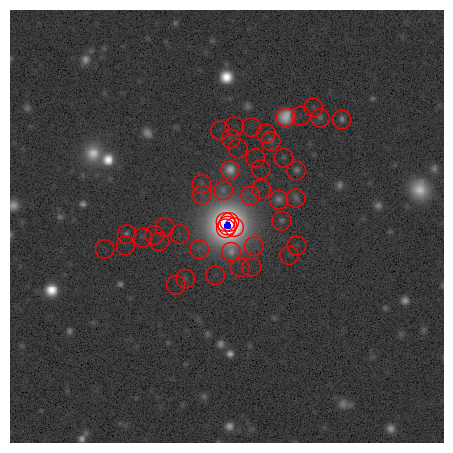

In [17]:
fig = plt.figure(figsize=(6, 6))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout.image)
with display.Buffering():
    display.dot('+', parents['x'][pi], parents['y'][pi], ctype=afwDisplay.BLUE)
    for ci in range(len(children)):
        display.dot('o', children['x'][ci], children['y'][ci],
                    size=10, ctype=afwDisplay.RED)
plt.gca().axis('off')
display.show_colorbar(False)
plt.show()

Well! Looks like a rich galaxy cluster.

> **Note:** Performance of the deblender is still being optimized, and results like this within DP0 are not necessarily representative of future results.

In [18]:
del parents, children, cutout

### 2.2. Find a parent at a given location

In the case where the user wants to explore the (de)blended objects at a specific location, the process is similar to the one above except here, no constraints are made _except_ spatial constraints.

In this case our search area is limited to a circle of radius 0.003 degrees, or about 10 arcseconds.

In [53]:
ra = 50.1089143
dec = -44.4812763
query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, patch, " + \
        "detect_isPrimary, deblend_nChild, deblend_skipped, " + \
        "detect_fromBlend, detect_isDeblendedModelSource, " +\
        "detect_isDeblendedSource, detect_isIsolated, parentObjectId, " + \
        "footprintArea, z_blendedness " + \
        "FROM dp02_dc2_catalogs_frdf.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", 0.003)) = 1 "
table = service.search(query).to_table()
table

objectId,coord_ra,coord_dec,x,y,tract,patch,detect_isPrimary,deblend_nChild,deblend_skipped,detect_fromBlend,detect_isDeblendedModelSource,detect_isDeblendedSource,detect_isIsolated,parentObjectId,footprintArea,z_blendedness
,deg,deg,pix,pix,,,,,,,,,,,pix,
int64,float64,float64,float64,float64,int64,int64,bool,int32,bool,bool,bool,bool,bool,int64,int32,float64
1248675773246614449,50.1112399,-44.4830789,23454.3378359,3177.9739026,2897,5,True,1,False,False,False,True,True,0,143,--
1248675773246647914,50.1068537,-44.4792151,23511.2949627,3247.0209205,2897,5,False,0,False,False,True,False,True,1248675773246615836,210,0.8789203
1248675773246647890,50.1089072,-44.4829201,23484.3230666,3180.5629998,2897,5,False,0,False,False,True,False,True,1248675773246615816,121,0.7908799
1248675773246646554,50.1112526,-44.4830634,23454.17738,3178.2537312,2897,5,False,0,False,False,True,False,True,1248675773246614449,196,0.7291283
1248675773246610542,50.1089142,-44.4812763,23484.4970041,3210.1552248,2897,5,False,13,False,False,False,False,False,0,3434,0.0
1248675773246610553,50.1057904,-44.4803281,23524.7723066,3226.8610979,2897,5,True,1,False,False,False,True,True,0,58,--
1248675773246615816,50.1088842,-44.4829725,23484.6103122,3179.6159975,2897,5,True,1,False,False,False,True,True,0,81,--
1248675773246615836,50.1068646,-44.4792123,23511.1551279,3247.0732585,2897,5,True,1,False,False,False,True,True,0,152,--


The fifth row in the results table is a parent source with 13 deblended children (it has `detect_isPrimary` = False, and `deblend_nChild` = 13).

Double check that all of the children are included in the `table` by finding out how many rows have a `parentObjectId` matching the first row's `objectId`.

In [62]:
sel_objid = table['objectId'][4]
whchild = np.where(table['parentObjectId'] == sel_objid)[0]
print(len(whchild), "child objects deblended from parentObjectId", sel_objid)

13 child objects deblended from parentObjectId 1248675773246610542


Up until now, the TAP service has been used to access catalog data.

Below, all objects in the same tract and patch as the 13-child parent are obtained via the butler.

In [63]:
tract = table['tract'][0]
patch = table['patch'][0]
dataId = {'tract': tract, 'patch': patch, 'band': 'i'}
obj = butler.get('objectTable', dataId)
print("Retrieved catalog of ", len(obj), " objects.")

Retrieved catalog of  31983  objects.


Print the parameters only for the objects that are children of the parent identified above.

In [64]:
children = obj[obj.parentObjectId == sel_objid]
children[['parentObjectId', 'x', 'y', 'coord_ra', 'coord_dec']]

column,parentObjectId,x,y,coord_ra,coord_dec
objectId,,,,,
1248675773246640603,1248675773246610542,23484.495497,3210.160832,50.108914,-44.481276
1248675773246640604,1248675773246610542,23466.945202,3233.628504,50.110297,-44.479981
1248675773246640605,1248675773246610542,23483.320677,3246.048343,50.109031,-44.479283
1248675773246640606,1248675773246610542,23512.928102,3205.707923,50.106698,-44.481509
1248675773246640607,1248675773246610542,23455.403218,3242.185135,50.111201,-44.479512
1248675773246640608,1248675773246610542,23488.090634,3231.687677,50.108649,-44.480078
1248675773246640609,1248675773246610542,23459.095831,3230.991759,50.110906,-44.480132
1248675773246640610,1248675773246610542,23495.093078,3184.436557,50.108071,-44.482700
1248675773246640611,1248675773246610542,23502.629718,3188.559530,50.107488,-44.482467


An alternative way of printing the `children` array defined above.

In [65]:
# for i in range(len(children)):
#     print(children.iloc[i].parentObjectId, children.index[i],
#           children.iloc[i].x, children.iloc[i].y,
#           children.iloc[i].coord_ra, children.iloc[i].coord_dec)

Another alternative for defining separate arrays containing the data from `children`,
and printing them with a user-specified format.

In [66]:
# obj_parentObjectId = np.asarray(obj.parentObjectId, dtype='int')
# obj_objectId = np.asarray(obj.index, dtype='int')
# obj_x = np.asarray(obj.x, dtype='float')
# obj_y = np.asarray(obj.y, dtype='float')
# obj_ra = np.asarray(obj.coord_ra, dtype='float')
# obj_dec = np.asarray(obj.coord_dec, dtype='float')

# wh = np.where(obj_parentObjectId == sel_objid)[0]
# print(len(wh), "child objects found for parentObjectId", sel_objid)

# for i in wh:
#     print('%20s %20s %10.3f %9.3f %10.6f %11.6f' %
#           (obj_parentObjectId[i], obj_objectId[i], obj_x[i], obj_y[i],
#            obj_ra[i], obj_dec[i]))

Obtain a cutout at the user-specified location.

In [67]:
cutout = cutout_coadd(butler, ra, dec, band='i', datasetType='deepCoadd',
                      cutoutSideLength=201)

bbox =  (minimum=(23384, 3110), maximum=(23584, 3310)) xy =  (23484, 3210) cutoutSize =  (201, 201)


Display a cutout at the location of this parent, and use the object data retrieved from the butler to mark the child locations.

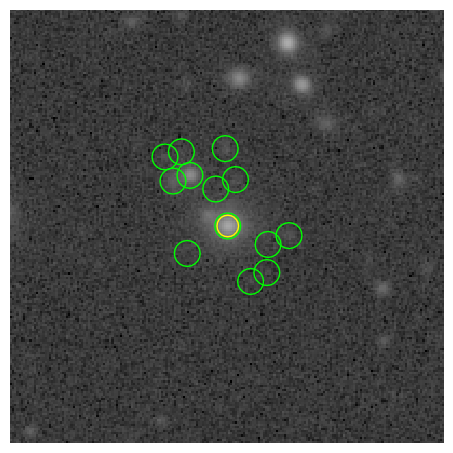

In [69]:
fig = plt.figure(figsize=(6, 6))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout.image)
with display.Buffering():
    display.dot('o', table['x'][4], table['y'][4], size=5,
                ctype=afwDisplay.YELLOW)
    for i in range(len(children)):
        display.dot('o', children.iloc[i].x, children.iloc[i].y,
                    size=6, ctype=afwDisplay.GREEN)
plt.gca().axis('off')
display.show_colorbar(False)
plt.show()

In [70]:
del table, obj, cutout

## 3. Deblended footprints

Scarlet, when run as part of the LSST Science Pipelines, produces the `deepCoadd_deblendedFlux` data product (among other outputs) after using the multi-wavelength images to identify peaks.
This data product contains the footprints for the individual deblended children, which might be a useful data product for some users.

The concept of a footprint was introduced in tutorial 05.
To quote [Bosch et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract), 

> *Footprints record the exact above-threshold detection region on a CCD. These are similar to  Source Extractor’s “segmentation map", in that they identify which pixels belong to which detected objects.*

This quote draws an analogy between footprints and segmentation maps, since they both identify pixels with values above some threshold. This is a useful similarity, since it gives us a place to start understanding the properties of footprints.


### 3.1. The `deepCoadd_deblendedFlux` table

Below, find the `deepCoadd_deblendedFlux` data product in the butler by searching for all dataset types with the word "blend" in the title.

In [71]:
registry = butler.registry
for dt in sorted(registry.queryDatasetTypes('*blend*')):
    print(dt)

DatasetType('deblend_config', {}, Config)
DatasetType('deblend_log', {skymap, tract, patch}, ButlerLogRecords)
DatasetType('deblend_metadata', {skymap, tract, patch}, PropertySet)
DatasetType('deepCoadd_deblendedFlux', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedFlux_schema', {}, SourceCatalog)


Look at the schema for the `deepCoadd_deblendedFlux` catalog to learn more about its contents.

Use the `dataId` as defined above for the 13-child parent galaxy of interest.

In [72]:
dataId

{'tract': 2897, 'patch': 5, 'band': 'i'}

We can first look at the contexts of `deepCoadd_deblendedFlux` by looking at the column names in `deepCoadd_deblendedFlux_schema` without having to pull the contents for the dataID from the butler.

In [73]:
dbFlux_schema = butler.get('deepCoadd_deblendedFlux_schema', dataId=dataId)
for colname in dbFlux_schema.asAstropy().colnames:
    print(colname)

id
coord_ra
coord_dec
parent
merge_footprint_i
merge_footprint_r
merge_footprint_z
merge_footprint_y
merge_footprint_g
merge_footprint_u
merge_footprint_sky
merge_peak_i
merge_peak_r
merge_peak_z
merge_peak_y
merge_peak_g
merge_peak_u
merge_peak_sky
deblend_runtime
deblend_iterations
deblend_nChild
deblend_deblendedAsPsf
deblend_tooManyPeaks
deblend_parentTooBig
deblend_masked
deblend_sedConvergenceFailed
deblend_morphConvergenceFailed
deblend_blendConvergenceFailedFlag
deblend_edgePixels
deblend_failed
deblend_error
deblend_skipped
deblend_peak_center_x
deblend_peak_center_y
deblend_peakId
deblend_peak_instFlux
deblend_modelType
deblend_nPeaks
deblend_parentNPeaks
deblend_parentNChild
deblend_scarletFlux
deblend_logL
deblend_spectrumInitFlag


Obtain the catalog contents for the `deepCoadd_deblendedFlux` table in the tract and patch defined by our `dataId`.

In [74]:
dbFlux = butler.get('deepCoadd_deblendedFlux', dataId=dataId)
dbFlux_table = dbFlux.asAstropy()
print('Retrieved', len(dbFlux_table),
      'records from the deepCoadd_deblendedFlux table.')

Retrieved 31983 records from the deepCoadd_deblendedFlux table.


For the 13 children associated with the parent identified in Section 2.2, display the catalog content.

In [76]:
tx = np.where(dbFlux_table['parent'] == sel_objid)[0]
dbFlux_table[tx]

id,coord_ra,coord_dec,parent,merge_footprint_i,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_u,merge_footprint_sky,merge_peak_i,merge_peak_r,merge_peak_z,merge_peak_y,merge_peak_g,merge_peak_u,merge_peak_sky,deblend_runtime,deblend_iterations,deblend_nChild,deblend_deblendedAsPsf,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_sedConvergenceFailed,deblend_morphConvergenceFailed,deblend_blendConvergenceFailedFlag,deblend_edgePixels,deblend_failed,deblend_error,deblend_skipped,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_peak_instFlux,deblend_modelType,deblend_nPeaks,deblend_parentNPeaks,deblend_parentNChild,deblend_scarletFlux,deblend_logL,deblend_spectrumInitFlag
,rad,rad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,,ct,,,,,,,
int64,float64,float64,int64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float32,int32,int32,bool,bool,bool,bool,bool,bool,bool,bool,bool,str25,bool,int32,int32,int32,float64,str25,int32,int32,int32,float32,float32,bool
1248675773246640603,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,True,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23485,3210,47292,5.382635593414307,MultiExtendedSource,1,13,13,488.44955,nan,True
1248675773246640604,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23467,3234,47294,2.392794370651245,MultiExtendedSource,1,13,13,107.06336,nan,True
1248675773246640605,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,True,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23483,3246,41242,0.33508533239364624,CompactExtendedSource,1,13,13,12.078945,nan,True
1248675773246640606,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23513,3206,47291,0.3286447525024414,CompactExtendedSource,1,13,13,12.831189,nan,True
1248675773246640607,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,False,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23455,3242,47295,0.260816365480423,CompactExtendedSource,1,13,13,5.9386506,nan,True
1248675773246640608,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23488,3231,47293,0.23755204677581787,CompactExtendedSource,1,13,13,9.693143,nan,True
1248675773246640609,nan,nan,1248675773246610542,True,True,True,True,True,True,False,False,False,False,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23459,3231,50403,0.3871372640132904,CompactExtendedSource,1,13,13,22.761833,nan,True
1248675773246640610,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,False,False,False,False,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23495,3185,40993,0.14222870767116547,CompactExtendedSource,1,13,13,3.7299385,nan,True


### 3.2. Exploring deblended footprints

Use the `.getFootprint()` method to get the footprints for all records in `dbFlux`,
and add them to the astropy table made from the `deepCoadd_deblendedFlux` table.
A new column called 'footprint' will appear in the `dbFlux_table`.

In [77]:
footprints = [src.getFootprint() for src in dbFlux]
dbFlux_table["footprint"] = footprints

For the 13 children associated with the parent identified in Section 2.2, display the catalog content, which now contains a `footprint` column (scroll all the way over to the right).

In [78]:
tx = np.where(dbFlux_table['parent'] == sel_objid)[0]
dbFlux_table[tx]

id,coord_ra,coord_dec,parent,merge_footprint_i,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_u,merge_footprint_sky,merge_peak_i,merge_peak_r,merge_peak_z,merge_peak_y,merge_peak_g,merge_peak_u,merge_peak_sky,deblend_runtime,deblend_iterations,deblend_nChild,deblend_deblendedAsPsf,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_sedConvergenceFailed,deblend_morphConvergenceFailed,deblend_blendConvergenceFailedFlag,deblend_edgePixels,deblend_failed,deblend_error,deblend_skipped,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_peak_instFlux,deblend_modelType,deblend_nPeaks,deblend_parentNPeaks,deblend_parentNChild,deblend_scarletFlux,deblend_logL,deblend_spectrumInitFlag,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,,ct,,,,,,,,
int64,float64,float64,int64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float32,int32,int32,bool,bool,bool,bool,bool,bool,bool,bool,bool,str25,bool,int32,int32,int32,float64,str25,int32,int32,int32,float32,float32,bool,object
1248675773246640603,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,True,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23485,3210,47292,5.382635593414307,MultiExtendedSource,1,13,13,488.44955,nan,True,"1 peaks, area=5840, centroid=(23484.5, 3217.97)"
1248675773246640604,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23467,3234,47294,2.392794370651245,MultiExtendedSource,1,13,13,107.06336,nan,True,"1 peaks, area=4324, centroid=(23479.5, 3223.66)"
1248675773246640605,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,True,True,True,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23483,3246,41242,0.33508533239364624,CompactExtendedSource,1,13,13,12.078945,nan,True,"1 peaks, area=3654, centroid=(23485.1, 3232.56)"
1248675773246640606,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23513,3206,47291,0.3286447525024414,CompactExtendedSource,1,13,13,12.831189,nan,True,"1 peaks, area=3187, centroid=(23497.7, 3211.95)"
1248675773246640607,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,False,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23455,3242,47295,0.260816365480423,CompactExtendedSource,1,13,13,5.9386506,nan,True,"1 peaks, area=1951, centroid=(23467.6, 3233.05)"
1248675773246640608,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,True,True,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23488,3231,47293,0.23755204677581787,CompactExtendedSource,1,13,13,9.693143,nan,True,"1 peaks, area=4762, centroid=(23485.3, 3224.44)"
1248675773246640609,nan,nan,1248675773246610542,True,True,True,True,True,True,False,False,False,False,False,True,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23459,3231,50403,0.3871372640132904,CompactExtendedSource,1,13,13,22.761833,nan,True,"1 peaks, area=3361, centroid=(23473, 3224.49)"
1248675773246640610,nan,nan,1248675773246610542,True,True,True,True,True,True,False,True,False,False,False,False,False,False,0.0,0,0,False,False,False,False,False,False,True,False,False,,False,23495,3185,40993,0.14222870767116547,CompactExtendedSource,1,13,13,3.7299385,nan,True,"1 peaks, area=2543, centroid=(23491.7, 3199.54)"


Use the function `heavyFootprint2Image` to turn the `footprint` into a `heavyFootprint` image. 
The function returns an image defined by a bounding box, and padded with fill value (the default is `NaN`)
which contains the projected flux in `heavy`.

The term "heavy" here refers to footprint pixels that aren't simply populated with values 0 or 1
(where 1 indicates the pixel is part of the footprint),
but with values that represent the flux.

In [79]:
fpimg = heavyFootprint2Image(dbFlux_table['footprint'][tx[0]])

*Optional:* Explore the properties of `fpimg` by uncommenting the line below, putting your cursor after the period, pressing tab, and scrolling through the pop-up box of attributes.
Recognize familiar image attributes such as `image` and `getBBox`.

In [80]:
# fpimg.

Display the footprint of each of the 13 deblended children in a 3x5 grid.

Title the subplot with the index and the footprint shape.
Notice that the footprint image areas are not a standard size: they encompass the footprint.

Remove the axis labels (x and y pixels) and the colorbar scale.
Note that this grid leaves 2 subplots empty, so erase the axes for the final two subplots.

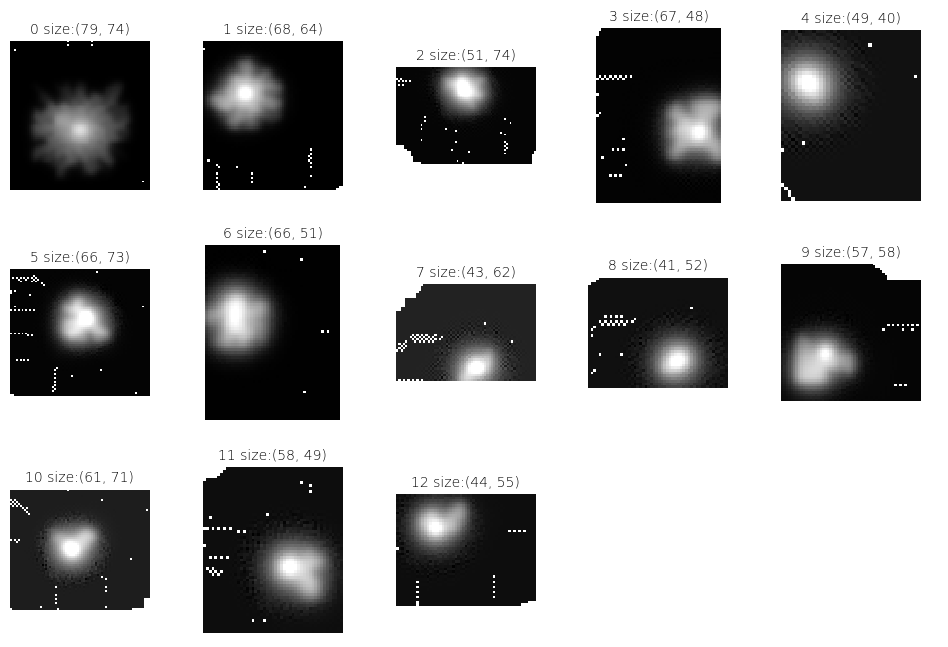

In [81]:
fig, ax = plt.subplots(3, 5, figsize=(10, 7))
display = afwDisplay.Display(frame=fig)

x = 0
for i in range(3):
    if i < 2:
        Nc = 5
    elif i == 2:
        Nc = 3
    for j in range(Nc):
        fpimg = heavyFootprint2Image(dbFlux_table['footprint'][tx[x]])
        plt.sca(ax[i, j])
        display.scale('asinh', 'zscale')
        display.mtv(fpimg.image)
        display.show_colorbar(False)
        plt.title(str(x) + " size:" + str(np.shape(fpimg.image.array)),
                  fontsize=10)
        plt.gca().axis('off')
        x += 1
        del fpimg

plt.sca(ax[2, 3])
display = afwDisplay.Display(frame=fig)
plt.gca().axis('off')
plt.sca(ax[2, 4])
display = afwDisplay.Display(frame=fig)
plt.gca().axis('off')

plt.tight_layout()
plt.show()

The above grid is somewhat useful for seeing the shapes of the individual footprints, but it does not show how the footprints might overlap with each other.

Below, plot all of the footprints together in a single axis. 

Define a set of 13 colormaps to use, one for each child footprint, and label each child footprint 0 through 12.

The `alpha` parameter is used here to set the pixel transparency in a fairly crude way, so that pixels are semi-transparent in the bright (high flux) areas of the footprint, and totally transparent in the outskirts of the footprint.

To make sure the final plot is big enough to hold all footprints, keep track of the min/max x/y values, and then use them to set the plot limits.

> **Note:** Due to the scaling, it *seems* like not all of these footprints touch, but since they are all deblended from a single parent, they do in fact join and overlap.
Adjust the values of `alpha` or try different `vmin` and `vmax` scaling to explore the footprint edges.

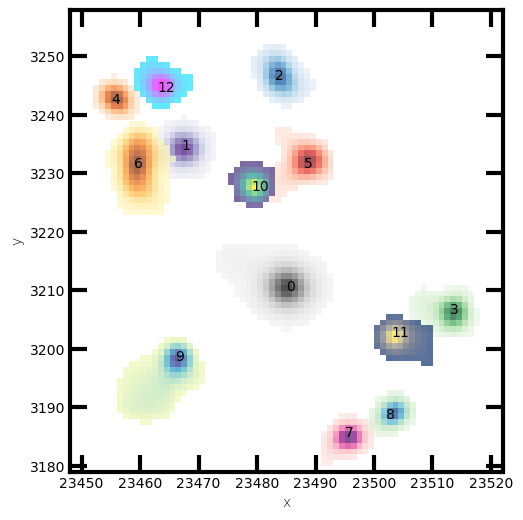

In [82]:
my_colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges',
                'Reds', 'YlOrBr', 'RdPu', 'GnBu', 'YlGnBu',
                'viridis', 'cividis', 'cool']
xmin = 9999999.
xmax = 0.
ymin = 9999999.
ymax = 0.

fig = plt.figure(figsize=(6, 6))
for x in range(len(tx)):
    fpimg = heavyFootprint2Image(dbFlux_table['footprint'][tx[x]])
    fpimg_extent = (fpimg.getBBox().beginX, fpimg.getBBox().endX,
                    fpimg.getBBox().beginY, fpimg.getBBox().endY)
    alphas = np.asarray(fpimg.image.array,
                        dtype='float') / np.nanmax(fpimg.image.array)
    tmp_x = np.where((np.isnan(alphas)) | (alphas < 0.1))
    alphas[tmp_x] = 0.0
    tmp_x = np.where(alphas >= 0.1)
    alphas[tmp_x] = 0.7
    im = plt.imshow(fpimg.image.array, cmap=my_colormaps[x], alpha=alphas,
                    vmin=np.nanmin(fpimg.image.array),
                    vmax=np.nanmax(fpimg.image.array),
                    extent=fpimg_extent, origin='lower')
    if xmin > fpimg.getBBox().beginX:
        xmin = fpimg.getBBox().beginX
    if xmax < fpimg.getBBox().endX:
        xmax = fpimg.getBBox().endX
    if ymin > fpimg.getBBox().beginY:
        ymin = fpimg.getBBox().beginY
    if ymax < fpimg.getBBox().endY:
        ymax = fpimg.getBBox().endY
    del fpimg, fpimg_extent, alphas, tmp_x, im

    center_x = dbFlux_table['deblend_peak_center_x'][tx[x]]
    center_y = dbFlux_table['deblend_peak_center_y'][tx[x]]
    plt.text(center_x, center_y, str(x), fontsize=10)

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('x', fontsize=10)
plt.ylabel('y', fontsize=10)
plt.tick_params(labelsize=10)
plt.show()

In [83]:
del dataId, dbFlux_schema, dbFlux, dbFlux_table
del footprints

## 4. Use-case: SN Ia host galaxy identification

DP0 <a href="https://dp0-2.lsst.io/tutorials-examples/portal-images.html">Portal tutorial 03</a> 
investigated the location of a Type Ia supernova (SN Ia) near a bright host galaxy and found that in some filters,
and with some image scaling parameters, it seemed like the true host is a fainter host
that is blended with a bigger, brighter galaxy.

The following steps use the techniques above to look for parent and child sources near this SN Ia.

Define the coordinates for this SN Ia.

In [84]:
sn_ra = 67.4579
sn_dec = -44.0802

Obtain the i-band `deepCoadd` image, which in Step 2.3 of Portal tutorial 03 reveals a potentially blended host.

In [85]:
cutout = cutout_coadd(butler, sn_ra, sn_dec, band='i', datasetType='deepCoadd',
                      cutoutSideLength=71)

bbox =  (minimum=(9577, 10429), maximum=(9647, 10499)) xy =  (9612, 10464) cutoutSize =  (71, 71)


Get the WCS for this cutout and convert the SN Ia coordinates from RA, Dec to pixels.

In [86]:
wcs = cutout.getWcs()
sn_radec = geom.SpherePoint(sn_ra, sn_dec, geom.degrees)
sn_xy = wcs.skyToPixel(sn_radec)

Display the i-band `deepCoadd` with the SN Ia location marked as a pink circle.

See how it seems like there's a faint galaxy there, blended with the larger one?

Try changing the scale from `asinh` to `linear` to get a different view.

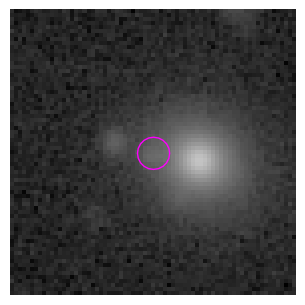

In [87]:
fig = plt.figure(figsize=(4, 4))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout.image)
with display.Buffering():
    display.dot('o', sn_xy.getX(), sn_xy.getY(), size=4,
                ctype=afwDisplay.MAGENTA)

plt.gca().axis('off')
display.show_colorbar(False)
plt.show()

Query the `Object` catalog for extended parents in the area. As a reminder, the spatial constraint by searching around a specified ra/dec is not technically necessary, but speeds up the query significantly because of the way the data in the object Table are stored (see Section 2.1).

In [88]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, " + \
        "patch, refExtendedness, detect_isPrimary, detect_isIsolated, " + \
        "deblend_nChild, detect_fromBlend, footprintArea, parentObjectId " + \
        "FROM dp02_dc2_catalogs_frdf.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(sn_ra) + ", " + str(sn_dec) + \
        ", 0.005)) = 1 " + \
        "AND refExtendedness = 1 AND deblend_nChild > 0"
parents = service.search(query).to_table()
parents

objectId,coord_ra,coord_dec,x,y,tract,patch,refExtendedness,detect_isPrimary,detect_isIsolated,deblend_nChild,detect_fromBlend,footprintArea,parentObjectId
,deg,deg,pix,pix,,,,,,,,pix,
int64,float64,float64,float64,float64,int64,int64,float64,bool,bool,int32,bool,int32,int64
1252220598734565711,67.4566195,-44.082423,9628.8981717,10423.760249,2905,16,1.0,True,True,1,False,67,0
1252220598734565679,67.4590236,-44.0849329,9597.9985836,10378.4542066,2905,16,1.0,True,True,1,False,141,0
1252220598734565690,67.4549104,-44.0838573,9651.1025428,10398.0321649,2905,16,1.0,True,True,1,False,160,0
1252220598734559348,67.4570197,-44.0803057,9623.5673563,10461.8499997,2905,16,1.0,False,False,32,False,11494,0
1252220598734559723,67.455304,-44.07586,9645.4269807,10541.9644436,2905,16,1.0,True,True,1,False,380,0


The table above reveals there is one nearby parent, with 32 children (identified by the deblend_nChild keyword). The other 5 sources you can see are not blends because they have detect_isIsolated = True.

Plot the location of this parent on the `deepCoadd` to see if it's the bright nearby galaxy.

objectId of parent with 32 children:  1252220598734559348


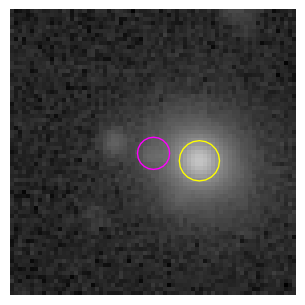

In [89]:
tx = np.where(parents['deblend_nChild'] == 32)[0]
print('objectId of parent with 32 children: ', parents['objectId'][tx[0]])

fig = plt.figure(figsize=(4, 4))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout.image)
with display.Buffering():
    display.dot('o', sn_xy.getX(), sn_xy.getY(), size=4,
                ctype=afwDisplay.MAGENTA)
    display.dot('o', parents['x'][tx], parents['y'][tx], size=5,
                ctype=afwDisplay.YELLOW)

plt.gca().axis('off')
display.show_colorbar(False)
plt.show()

Query for the 32 children of this parent.

In [90]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, patch, " + \
        "refExtendedness, detect_isPrimary, deblend_nChild, " + \
        "detect_fromBlend, footprintArea, parentObjectId " + \
        "FROM dp02_dc2_catalogs_frdf.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(sn_ra) + ", " + str(sn_dec) + \
        ", 0.01)) = 1 AND parentObjectId = 1252220598734559348"
children = service.search(query).to_table()
# children

Plot the locations of the children as green circles.

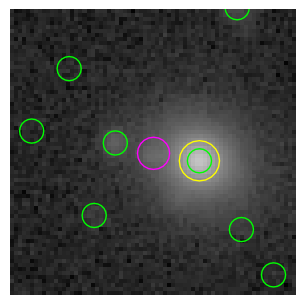

In [91]:
fig = plt.figure(figsize=(4, 4))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout.image)
with display.Buffering():
    display.dot('o', sn_xy.getX(), sn_xy.getY(), size=4,
                ctype=afwDisplay.MAGENTA)
    display.dot('o', parents['x'][tx], parents['y'][tx], size=5,
                ctype=afwDisplay.YELLOW)
    for i in range(len(children)):
        display.dot('o', children['x'][i], children['y'][i], size=3,
                    ctype=afwDisplay.GREEN)

plt.gca().axis('off')
display.show_colorbar(False)
plt.show()

Well! What seems to be the true host galaxy has not been deblended from the large, bright, nearby galaxy.

This might be a good case where the deblender should be run, with more aggressive deblending parameters,
but that is an intermediate/advanced level use of the LSST Science Pipelines that is left to a different tutorial.

## 5. Exercise for the learner

Further explore the footprints of the children around this SN Ia.
Create a footprints plot similar to the one in Section 3.2.